In [95]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform as skt
from PIL import Image
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['image.cmap'] = 'gray'

Basic white noise?

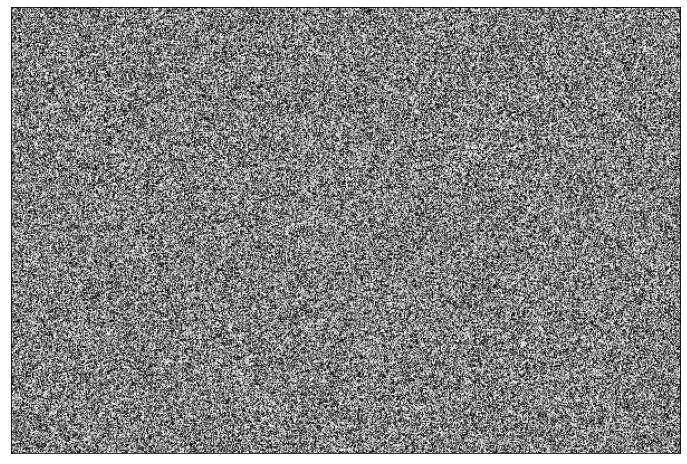

In [96]:
# Create random noise image
rng = np.random.default_rng()
white_noise = rng.random((400, 600))

# Show image
plt.imshow(white_noise)
plt.xticks([])
plt.yticks([]);

Seems kind of boring. What if we generated a random image, and then scaled it up, interpolating between the sampled points to create a smooth boundary

I think this is called value noise.

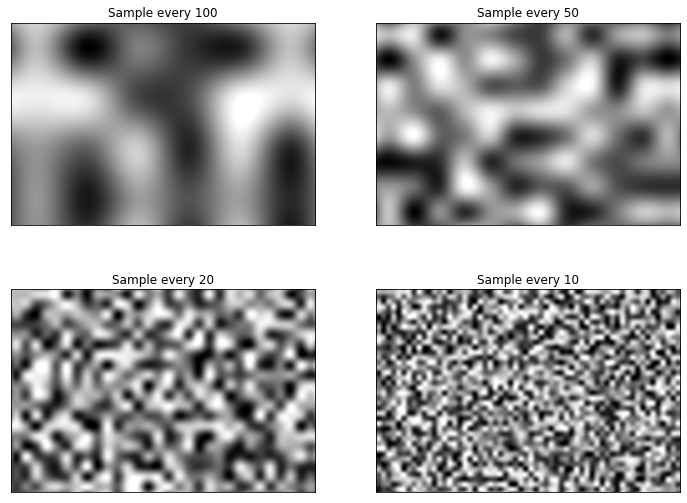

In [97]:
def sample(r):
    """
    Sample points within the buffer.
    Then rescale while cubically 
    interpolating between points
    This can be done using scikit-image's
    rescale function. We set the order to
    3 to indicate cubic interpolation
    """
    ips = np.arange(0, 600, r)
    jps = np.arange(0, 400, r)
    j,i = np.meshgrid(ips,jps)
    return skt.rescale(white_noise[i,j], r, order=3)

# Get some samples
sample_0 = sample(100)
sample_1 = sample(50)
sample_2 = sample(20)
sample_3 = sample(10)

# Show image
plt.figure()
plt.subplot(2,2,1)
plt.imshow(sample_0)
plt.title('Sample every 100')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(sample_1)
plt.title('Sample every 50')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,3)
plt.imshow(sample_2)
plt.title('Sample every 20')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,4)
plt.imshow(sample_3)
plt.title('Sample every 10')
plt.xticks([])
plt.yticks([]);

What's more: We can sum these individual noise points together to create a more complex pattern, called fractal noise.

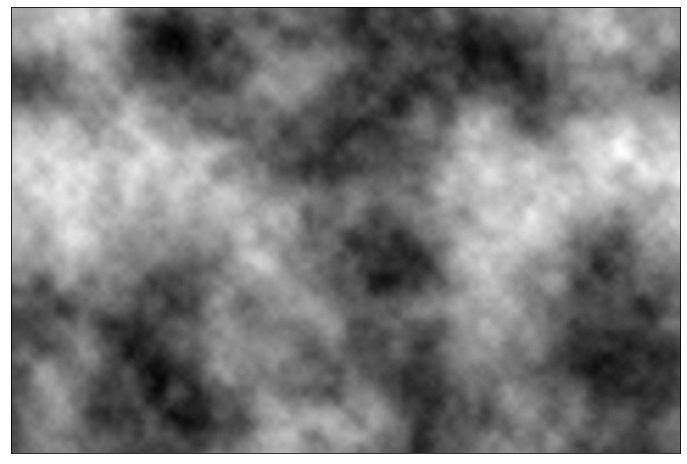

In [98]:
# Parameters
# Scales are all common factors of the image dimensions
scales = [ 100, 50, 20, 10, 5, 1 ]

# Get sampled images and factors
sampled_images = np.array([ sample(scale) for scale in scales ])
factors = np.array([ [[0.5**i]] for i in range(len(scales)) ])

# Noise is a normalized weighted sum of these samples
fractal_noise = (factors*sampled_images).sum(axis=0)
fractal_noise /= factors.sum(axis=0)

# Show image
plt.figure()
plt.imshow(fractal_noise)
plt.xticks([])
plt.yticks([]);

Pretty nifty... pretty nifty... but I want to do more... what if we offset the points using more noise?

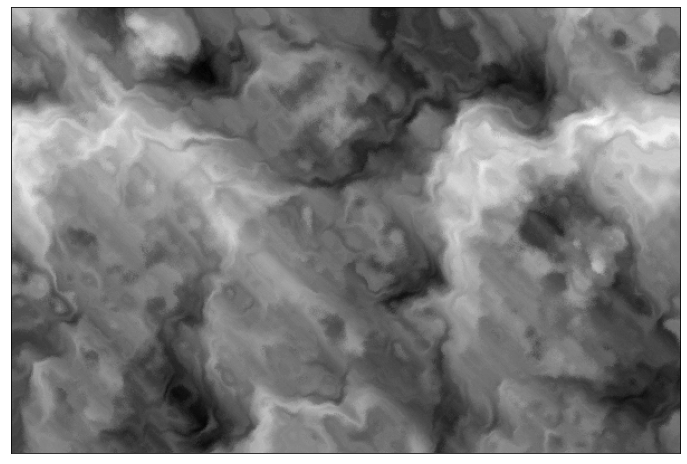

In [99]:
def make_noise():
    # Scales are all common factors of the image dimensions
    scales = [ 100, 50, 20, 10, 5, 1 ]

    # Get sampled images and factors
    sampled_images = np.array([ sample(scale) for scale in scales ])
    factors = np.array([ [[0.5**i]] for i in range(len(scales)) ])

    # Noise is a normalized weighted sum of these samples
    fractal_noise = (factors*sampled_images).sum(axis=0)
    fractal_noise /= factors.sum(axis=0)
    return fractal_noise

# Create noise and map to an offset factor
offset = 90
offset_noise = ( make_noise() * offset * 2 - offset ).astype( np.int8 )

# Offset the noise buffer using te offsets generated
j_index, i_index = np.meshgrid(np.arange(600), np.arange(400))
i_offset = np.clip(offset_noise + i_index, 0, 399)
j_offset = np.clip(offset_noise + j_index, 0, 599)

# Update offset_noise
offsetted_noise = fractal_noise[i_offset, j_offset]
        
# Normalize
offsetted_min = np.min(offsetted_noise)
offsetted_max = np.max(offsetted_noise)
offsetted_noise = (offsetted_noise - offsetted_min) / (offsetted_max - offsetted_min)
     
# Show image
plt.figure()
plt.imshow(offsetted_noise)
plt.xticks([])
plt.yticks([]);

Now THAT's what I'm looking for! Let's add some color to this! I'm using a simple gradient, where 0 is mapped to a start color and 1 is mapped to an ending color, and all numbers in between linearly interpolate between those colors!

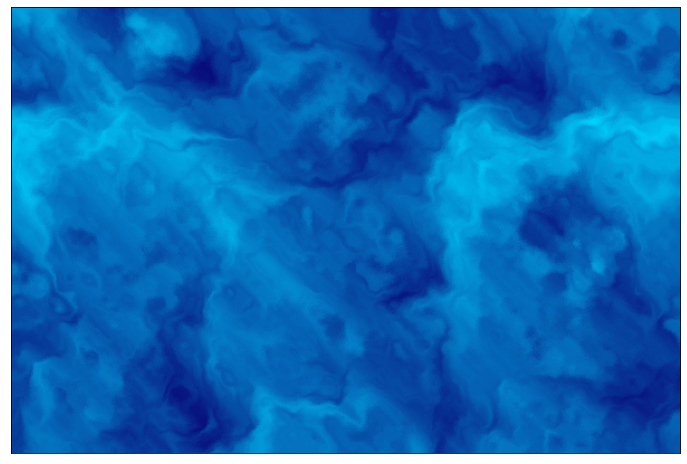

In [100]:
# Starting and ending colors
start = np.array([[[0x09, 0x09, 0x79]]]) # #090979
end = np.array([[[0x00, 0xd4, 0xff]]]) # #00d4ff

# Combining
gray_offsetted_noise = offsetted_noise.reshape(400,600,1)
colored_offsetted_noise = (1 - gray_offsetted_noise) * start + gray_offsetted_noise * end
colored_offsetted_noise = colored_offsetted_noise.astype(np.uint8)

plt.figure()
plt.imshow(colored_offsetted_noise)
plt.xticks([])
plt.yticks([]);

Alright, it's ready for an iphone wallpaper. Let's do it all again!

In [101]:
# Image dimensions
height = 1800
width = 900

# Generate a new white noise buffer
white_noise = rng.random((height, width))

def sample(r):
    """
    Sample points within the buffer.
    Then rescale while cubically 
    interpolating between points
    This can be done using scikit-image's
    rescale function. We set the order to
    3 to indicate cubic interpolation
    """
    ips = np.arange(0, height, r)
    jps = np.arange(0, width, r)
    j,i = np.meshgrid(jps,ips)
    return skt.rescale(white_noise[i,j], r, order=3)

# Scales are all common factors of the image dimensions
scales = [ 300, 100, 50, 20, 10, 5, 1 ]

# Get sampled images and factors
sampled_images = np.array([ sample(scale) for scale in scales ])
factors = np.array([ [[0.5**i]] for i in range(len(scales)) ])

# Noise is a normalized weighted sum of these samples
fractal_noise = (factors*sampled_images).sum(axis=0)
fractal_noise /= factors.sum(axis=0)

# Generate offset noise
offset = 200
offset_noise = ( fractal_noise * offset * 2 - offset ).astype(np.int16)

# Offset the noise buffer using te offsets generated
j_index, i_index = np.meshgrid(np.arange(width), np.arange(height))
i_offset = np.clip(offset_noise + i_index, 0, height - 1)
j_offset = np.clip(offset_noise + j_index, 0, width - 1)

# Update offset_noise
offsetted_noise = fractal_noise[i_offset, j_offset]
        
# Normalize
offsetted_min = np.min(offsetted_noise)
offsetted_max = np.max(offsetted_noise)
offsetted_noise = (offsetted_noise - offsetted_min) / (offsetted_max - offsetted_min)

# Starting and ending colors
start = np.array([[[0x09, 0x09, 0x79]]]) # #090979
end = np.array([[[0x00, 0xd4, 0xff]]]) # #00d4ff

# Combining
gray_offsetted_noise = offsetted_noise.reshape(height,width,1)
colored_offsetted_noise = (1 - gray_offsetted_noise) * start + gray_offsetted_noise * end
colored_offsetted_noise = colored_offsetted_noise.astype(np.uint8)

# Saving image
img = Image.fromarray(colored_offsetted_noise)
img.save('data/wallpaper.png')